# Sequence Model
For the probability distribution

$$P(x_t \mid x_{t-1}, \ldots, x_1)$$


While estimating the entire distribution
over a continuously valued random variable
can be difficult, we can
focus on a few key statistics of the distribution,
particularly the expected value and the variance.
One simple strategy for estimating the conditional expectation

$$\mathbb{E}[(x_t \mid x_{t-1}, \ldots, x_1)],$$

would be to apply a linear regression model
(recall :numref:`sec_linear_regression`).
Such models that regress the value of a signal
on the previous values of that same signal
are naturally called *autoregressive models*.

## Some strategies

1. when predicting the near future, we might content ourselves
to condition on some window of length $\tau$
and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations. When $\tau = 1$, we say that the data is characterized
by a *first-order* **Markov model**,
and when $\tau = k$, we say that the data is characterized
by a $k^{\textrm{th}}$-order Markov model.


2. we might develop models that maintain
some summary $h_t$ of the past observations
(see :numref:`fig_sequence-model`)
and at the same time update $h_t$
in addition to the prediction $\hat{x}_t$.
This leads to models that estimate not only $x_t$
with $\hat{x}_t = P(x_t \mid h_{t})$
but also updates of the form
$h_t = g(h_{t-1}, x_{t-1})$.
Since $h_t$ is never observed,
these models are also called
*latent autoregressive models*.

![A latent autoregressive model.](../img/sequence-model.svg)
:label:`fig_sequence-model`




In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

tensor([True, True, True, True])


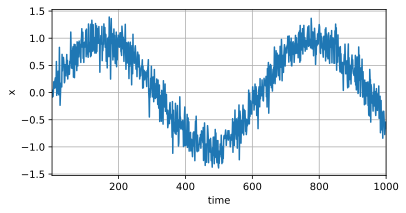

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)] # 1000-tau = 996 examples
        self.features = torch.stack(features, 1) # concat along the 1st dimension
        self.labels = self.x[self.tau:].reshape((-1, 1)) # we don't have enough `tau` features for the first `tau` examples
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

data = Data()
features = [data.x[i : data.T-data.tau+i] for i in range(data.tau)]
print(torch.stack(features, 1)[0] == torch.tensor([features[0][0], features[1][0], features[2][0], features[3][0]]))
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


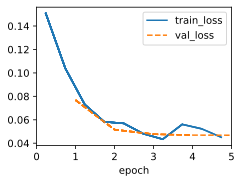

In [11]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

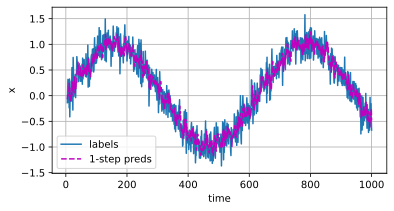

In [12]:
"""Prediction"""
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

If we train for 600 inputs, then how can we predict the subsequent time steps ifwe don't have the inputs for 601, 602, etc?
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$\begin{aligned}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
&\vdots\end{aligned}$$

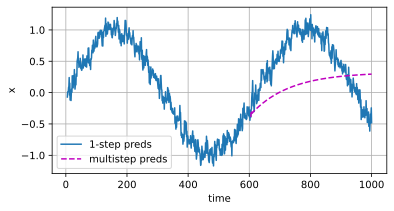

In [13]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

=> FAILED

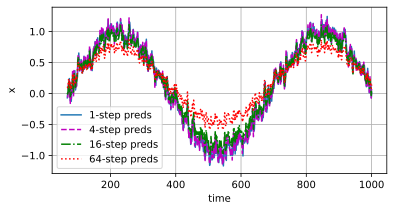

In [14]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

# Converting Text into Sequence Data

In [15]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [3]:
class TimeMachine(d2l.DataModule): # @save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + "timemachine.txt", self.root,
                             "090b5e7e70c295757f55df93cb0a180b9691891a")
        with open(fname) as f:
            return f.read()

    def _tokenize(self, text):
        return list(text)
    
    def _preprocess(self, text):
        """ ignore case and punctuation """
        return re.sub("[^A-Za-z]+", " ", text).lower()

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: 
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [55]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [56]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [4]:
class Vocab: #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
            
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse = True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(["<unk>"] + reserved_tokens + 
                                            [token for token, freq in self.token_freqs if freq >= min_freq]
                                           )))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}


    
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk) # if not found, return "<unk>"
        return [self.__getitem__(token) for token in tokens] # recursive 
    
    def to_tokens(self, indices):
        if hasattr(indices, "__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[int(indices)]
    
    @property
    def unk(self):
        return self.token_to_idx["<unk>"]

In [58]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [98]:
corpus, vocab = data.build(raw_text)
print(corpus[0])
len(corpus), len(vocab)

21


(173428, 28)

In [61]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

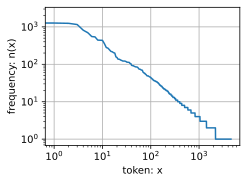

In [62]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

After dealing with the first few words as exceptions,
all the remaining words roughly follow a straight line on a log--log plot.
This phenomenon is captured by *Zipf's law*,
which states that the frequency $n_i$
of the $i^\textrm{th}$ most frequent word is:

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

which is equivalent to

$$\log n_i = -\alpha \log i + c,$$

where $\alpha$ is the exponent that characterizes
the distribution and $c$ is a constant.

# How to learn language models

The goal of *language models*
is to estimate the joint probability of the whole sequence:

$$P(x_1, x_2, \ldots, x_T),$$

Suppose that we tokenize text data at the word level.
Let's start by applying basic probability rules:

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

For example, 
the probability of a text sequence containing four words would be given as:

$$\begin{aligned}&P(\textrm{deep}, \textrm{learning}, \textrm{is}, \textrm{fun}) \\
=&P(\textrm{deep}) P(\textrm{learning}  \mid  \textrm{deep}) P(\textrm{is}  \mid  \textrm{deep}, \textrm{learning}) P(\textrm{fun}  \mid  \textrm{deep}, \textrm{learning}, \textrm{is}).\end{aligned}$$


## Markov models & n-grams

A distribution over sequences satisfies the Markov property of first order if $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4) --> \it unigram,\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3) --> \it bigram,\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3). --> \it trigram
\end{aligned}
$$


## Word Frequency

Here, assume a large training corpus. Relative frequency of words in corpus -> Probability of predicted words.

$$\hat{P}(\textrm{learning} \mid \textrm{deep}) = \frac{n(\textrm{deep, learning})}{n(\textrm{deep})},$$

where $n(x)$ and $n(x, x')$ are the number of occurrences of singletons
and consecutive word pairs, respectively.

For word *pairs* and beyond, this becomes **very inaccurate**. 

This method entirely **ignores the meaning** of the words. For instance, “cat” and “feline” should occur in related contexts. It is quite difficult to adjust such models to additional contexts, whereas, deep learning based language models are well suited to take this into account. Last, long word sequences are almost certain to be novel, hence a model that simply counts the frequency of previously seen word sequences is bound to perform poorly there. 

# Perplexity / How to measure the Quality of Language Models

Too difficult to compute the likelihood of a sequence because sequences can be of different lengths.

=> Information entropy helps, especially **surprisal** and **cross-entropy**.

The cross-entropy loss averaged
over all the $n$ tokens of a sequence:

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
:eqlabel:`eq_avg_ce_for_lm`

where $P$ is given by a language model and $x_t$ is the actual token observed at time step $t$ from the sequence.

For historical reasons, scientists use **perplexity**, which is the *exponential of the above quantity*:

$$\exp\left(\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)\right),$$

which is the distribution over the vocabulary for the next word. In other words, how many **different equally probable** words can follow the given sequence.

=> Lower perplexity = better *language* model

### **[READ THIS](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)**


## Partitioning text into sequences
Suppose that the dataset takes the form of a sequence of $T$ token indices in `corpus`.
We will
partition it
into subsequences, where each subsequence has $n$ tokens (time steps).

at the beginning of each epoch,
discard the first $d$ tokens,
where $d\in [0,n)$ is uniformly sampled at random.
The rest of the sequence
is then partitioned
into $m=\lfloor (T-d)/n \rfloor$ subsequences.
Denote by $\mathbf x_t = [x_t, \ldots, x_{t+n-1}]$ the length-$n$ subsequence starting from token $x_t$ at time step $t$. 
The resulting $m$ partitioned subsequences
are 
$\mathbf x_d, \mathbf x_{d+n}, \ldots, \mathbf x_{d+n(m-1)}.$
Each subsequence will be used as an input sequence into the language model.

In [5]:
class TimeMachine(d2l.DataModule): # @save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + "timemachine.txt", self.root,
                             "090b5e7e70c295757f55df93cb0a180b9691891a")
        with open(fname) as f:
            return f.read()

    def _tokenize(self, text):
        return list(text)
    
    def _preprocess(self, text):
        """ ignore case and punctuation """
        return re.sub("[^A-Za-z]+", " ", text).lower()

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: 
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

@d2l.add_to_class(d2l.TimeMachine) #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    """
    `batch_size`: specifies the number of subsequence examples in each minibatch
    `num_steps`: the subsequence length (in tokens not characters).
    """
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus) - num_steps)])
    self.X, self.Y = array[:, :-1], array[:,1:] # X is input, Y is label (list of the next characer in each sequence)

@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx) # get_tensorloader will randomize the dataset

In [72]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 2, 15,  0, 20, 22,  3, 14, 10, 21, 21],
        [ 4,  9,  0,  7,  6, 13, 13,  0, 22, 17]]) 
Y: tensor([[15,  0, 20, 22,  3, 14, 10, 21, 21,  6],
        [ 9,  0,  7,  6, 13, 13,  0, 22, 17, 16]])


# Recurrent Neural Networks (RNNs)
Assume a minibatch of inputs
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
at time step $t$. In practice, each token is represented by a $d$-dimensional vector.
In other words,
for a minibatch of $n$ sequence examples,
each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence.


$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$: the hidden layer output of time step $t$.


Unlike with MLP, here we save the hidden layer output $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden layer output of the previous time step in the current time step. Specifically, the calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h}).$$
:eqlabel:`rnn_h_with_state`

Compared with MLP, :eqref:`rnn_h_with_state` adds one more term $\mathbf{H}_{t-1}$ . $\mathbf{H}_t$ is called **hidden output**.

For time step $t$,
the output of the output layer is similar to the computation in the MLP:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}.$$

Parameters of the RNN
include the weights $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}, \mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$,
and the bias $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$
of the hidden layer,
together with the weights $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$
and the bias $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$
of the output layer.
Even at **different time steps**,
RNNs always use these **same model parameters**.
Therefore, the **parametrization cost** of an RNN
does **NOT grow** as the number of time steps increases.

![An RNN with a hidden state.](../img/rnn.svg)

In [6]:
class RNNScratch(d2l.Module): #@save
    """The RNN model implemented from scratch"""
    
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        """
        num_inputs: one-hot vector (of len == the vocab size) representing each token.
        num_hiddens: # of hidden units
        """
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens)* sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        """
        state: hidden state of the previous time step
        Shape of `inputs`: (num_steps, batch_size, num_inputs)
        `num_steps`: how long a sequence is (in tokens).
        `num_inputs`: one-hot vector (of len == the vocab size) representing each token.
        """
        if state is None: # first pass
             # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else: 
            state, = state

        outputs = []
        for X in inputs:
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
    

In [9]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
outputs, state = rnn.forward(torch.ones((num_steps, batch_size, num_inputs)))

In [10]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [11]:


class RNNLMScratch(d2l.Classifier): #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def one_hot(self, X):
        """
        Input shape: (batch_size, num_steps)
        Output shape: (num_steps, batch_size, vocab_size)
        """
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def training_step(self, batch):
        """
        loss here is perplexity
        `self.loss` returns the cross-entropy loss, we exponentiate it to get perplexity
        """
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True) 
        return l

    def validation_step(self, batch):
        """
        loss here is perplexity
        `self.loss` returns the cross-entropy loss, we exponentiate it to get perplexity
        """
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
        return l

    def output_layer(self, rnn_outputs):
        """
        rnn_outputs: vector of H_t for all time steps t
        returns output list of all time steps
        """
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def one_hot(self, X):
        """
        Input shape: (batch_size, num_steps)
        Output shape: (num_steps, batch_size, vocab_size)
        """
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

In [110]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [102]:
#print(F.one_hot(torch.tensor([[0, 1, 2], [3, 4, 5]])))
#print(data.X)

## Gradient Clipping
Prevents gradients from exploding: each input has to go through $\mathbf{N}$ time steps in order to influence the final time step. Backprop gives us $\mathbf{({W}^T)}^N$ as the gradient. Assume that $\mathbf{W}^T$ is [diagonalizable](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48), we have $\mathbf{({W}^T)}^N = QD^{N}Q^{-1}$, where $\mathbf{D}$ is a diagonal matrix. 

=> Gradient grows/shrinks exponentially.

A **gradient clipping** heuristic
projecting the gradients $\mathbf{g}$ onto a ball 
of some given radius $\theta$ as follows:

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

This ensures that the gradient norm never exceeds $\theta$ 
and that the updated gradient is entirely aligned 
with the original direction of $\mathbf{g}$.


## Prediction
Predict beyond 1 token. Use previous results as if it was input.

In [13]:
@d2l.add_to_class(d2l.Trainer) #@save
def clip_gradients(self, grad_clip_val, model):
    params = [param for param in model.parameters() if param.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p**2)) for p in params))
    if norm > grad_clip_val:
        for param in params: 
            param.grad[:] *= grad_clip_val / norm

@d2l.add_to_class(RNNLMScratch) #@save
def predict(self, prefix, num_preds, vocab, state=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([ [outputs[-1]] ], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)

        if i < len(prefix) - 1: # warm-up period
            outputs.append(vocab[prefix[i+1]])
        else:
            Y = self.output_layer(rnn_outputs) # returns a vector of len == vocab size containing 
            outputs.append(int(Y.argmax(dim=2).reshape(1))) # get the most likely token idx
    return ''.join([vocab.idx_to_token[i] for i in outputs])
        

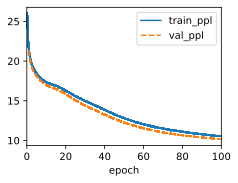

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [137]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

# Coincise RNN Implementation

In [14]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        """
        num_inputs: one-hot vector (of len == the vocab size) representing each token.
        """
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

    

In [142]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab) # haven't trained so scuffed predictions

/Users/wechicken456/miniconda3/envs/d2l/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'it haswyyyyyyyyyyyyyyyyyyy'

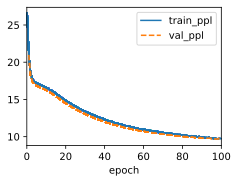

In [143]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [145]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has an the the the the '